###### Imports

In [1]:
import torch.nn as nn
import torch

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from data.dataloader import data_generator, data_generator_real_data
from models.losses import loss_function_mat, log_spectrum_mse

In [4]:
from models.gru_denoiser import BiGRUSpectralDenoiser

In [5]:
from training.trainer import Trainer

In [6]:
from data.real_dataloader import real_data_pipeline

In [7]:
from estimator.QIS import QIS_batched
from estimator.MLE import torch_cov_pairwise
from estimator.nearest_correlation.nearest_correlation import nearcorr_batch

## NN

To find the best way of estimating $\Sigma_{true}$ and prove that our method is the best we compute $\Sigma$ with different technique and at the end we compute the loss and compare which is the lowest  
For now the missingness pattern is monotone only, but easily extensible (just remove shaffer when pattern of missingness is different)
- with no data missingness
    - $\Sigma_{QIS}$
    - $\Sigma_{NN}$
    - $\Sigma_{cov}$
    - Nearest covariance matrix https://github.com/mikecroucher/nearest_correlation
- with data missingness
    - $\Sigma_{NN}$
    - $\Sigma_{cov}$
    - Shaffer (TODO) (monotone pattern only)

In [8]:
mse = nn.MSELoss()

In [9]:
N_min = 70
N_max = 250
T_min = 30
T_max = 70
batch_size=100

### Training loop — Generated Data

In [10]:
model_generated_data = BiGRUSpectralDenoiser(hidden_size=96) # hidden_size to be tunned 
# lr, weight_decay, batch_size, epochs, hidden_size to be tunned

In [11]:
trainer = Trainer(
    model=model_generated_data, is_train_on_real_data = False, loss_function=loss_function_mat, data_generator=data_generator, lr = 1e-4, weight_decay=1e-5,
    batch_size=batch_size, epochs=50, N_min=N_min, N_max=N_max, T_min=T_min, T_max=T_max, log_interval=10, accumulate_steps=2, dataset=None, missing_constant = 2,
)
# need to epochs to be big when there is lot of choise for N and T 
# need for big batch_size when df is big
losses = trainer.train()

Starting training for 50 epochs…
Epoch 10/50 — loss: 0.00662292
Epoch 20/50 — loss: 0.01265136
Epoch 30/50 — loss: 0.01953516
Epoch 40/50 — loss: 0.00588766
Epoch 50/50 — loss: 0.00847981
Training complete.


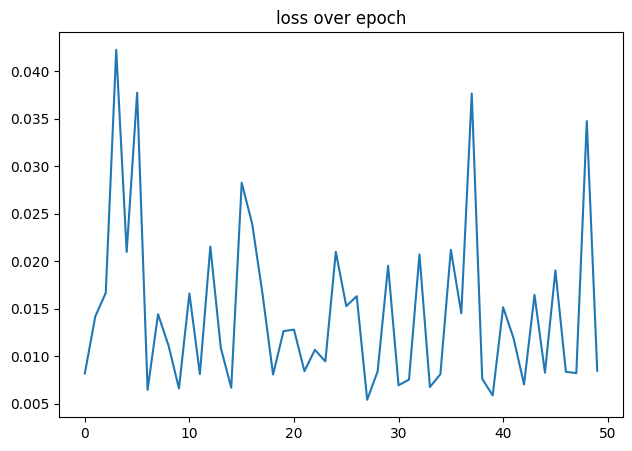

In [29]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("loss over epoch")
plt.savefig("images/training_loss.png")
plt.show()

In [13]:
# save the model
torch.save(model_generated_data.state_dict(), "models/spectral_denoiser_model_generated.pth")

we have to stop after the slow down of deacrese. otherwise we might face overfitting

In [14]:
state_dict_generated_data = torch.load("models/spectral_denoiser_model_generated.pth")
model_generated_data.load_state_dict(state_dict_generated_data)
model_generated_data.eval()

BiGRUSpectralDenoiser(
  (gru): GRU(6, 96, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=192, out_features=1, bias=True)
  (activation): Softplus(beta=1.0, threshold=20.0)
)

### Comparaison (oos)

In [15]:
batch_size_oos = 500

In [16]:
input_seq_cov_miss, Q_emp_miss, Sigma_true_miss, T, Sigma_hat_diag_miss, R_miss          = next(data_generator(batch_size_oos, missing_constant = 2, N_min=60, N_max=60, T_min=30, T_max=30))
input_seq_cov_no_miss, Q_emp_no_miss, Sigma_true_no_miss, T, Sigma_hat_diag_no_miss, R_no_miss = next(data_generator(batch_size_oos, missing_constant = 1, N_min=60, N_max=60, T_min=30, T_max=30))

In [17]:
lam_emp_miss     = input_seq_cov_miss[:,:,0]
lam_pred_miss    = model_generated_data(input_seq_cov_miss) # ,lam_emp_miss
lam_emp_no_miss  = input_seq_cov_no_miss[:,:,0]
lam_pred_no_miss = model_generated_data(input_seq_cov_no_miss) # ,lam_emp_no_miss

In [31]:
lam_emp_miss[0]

tensor([ 7.1442e+00,  6.3766e+00,  5.7501e+00,  4.8947e+00,  4.5940e+00,
         4.3474e+00,  3.4679e+00,  3.1303e+00,  3.0439e+00,  2.7556e+00,
         2.5249e+00,  2.1768e+00,  2.0880e+00,  1.8605e+00,  1.6933e+00,
         1.5556e+00,  1.3316e+00,  1.2233e+00,  9.7494e-01,  7.1576e-01,
         6.6511e-01,  5.0925e-01,  4.0076e-01,  3.4034e-01,  3.1932e-01,
         1.7750e-01,  2.7755e-02,  1.1171e-03, -1.7565e-02, -2.1015e-02,
        -2.6625e-02, -2.8302e-02, -3.0634e-02, -3.2613e-02, -3.4520e-02,
        -3.9833e-02, -4.2286e-02, -4.6858e-02, -5.0983e-02, -5.4530e-02,
        -6.1587e-02, -6.8805e-02, -7.2929e-02, -7.5408e-02, -8.1723e-02,
        -8.7120e-02, -1.1337e-01, -1.2235e-01, -1.3877e-01, -1.4150e-01,
        -1.5624e-01, -1.6301e-01, -1.9032e-01, -2.1303e-01, -2.5015e-01,
        -2.7325e-01, -3.1303e-01, -3.4443e-01, -3.8466e-01, -4.1321e-01])

In [30]:
lam_pred_miss[0]

tensor([0.7773, 0.7845, 0.7773, 0.7831, 0.7773, 0.7780, 0.7747, 0.7685, 0.7807,
        0.7777, 0.7745, 0.7709, 0.7740, 0.7720, 0.7675, 0.7607, 0.7648, 0.7762,
        0.7678, 0.7752, 0.7720, 0.7752, 0.7711, 0.7700, 0.7745, 0.7714, 0.7718,
        0.7730, 0.7681, 0.7462, 0.7651, 0.7624, 0.7606, 0.7535, 0.7534, 0.7620,
        0.7606, 0.7462, 0.7637, 0.7530, 0.7466, 0.7607, 0.7451, 0.7530, 0.7513,
        0.7480, 0.7490, 0.7502, 0.7426, 0.7420, 0.7495, 0.7377, 0.7495, 0.7455,
        0.7433, 0.7381, 0.7380, 0.7255, 0.7197, 0.6994],
       grad_fn=<SelectBackward0>)

Comparaison matrix $Corr$

In [18]:
Corr_pred_miss    = Q_emp_miss @ torch.diag_embed(lam_pred_miss) @ Q_emp_miss.transpose(1,2)
Corr_pred_no_miss = Q_emp_no_miss @ torch.diag_embed(lam_pred_no_miss) @ Q_emp_no_miss.transpose(1,2)
Corr_emp_miss     = Q_emp_miss @ torch.diag_embed(lam_emp_miss) @ Q_emp_miss.transpose(1,2)
Corr_emp_no_miss  = Q_emp_no_miss @ torch.diag_embed(lam_emp_no_miss) @ Q_emp_no_miss.transpose(1,2)

In [19]:
diag_oos_miss  = torch.diagonal(Sigma_true_miss, dim1=-2, dim2=-1)
std_oos_miss   = torch.sqrt(torch.clamp(diag_oos_miss, min=1e-12))
Corr_true_miss = Sigma_true_miss / (std_oos_miss[:, None, :] * std_oos_miss[:, :, None] + 1e-12)


diag_oos_no_miss  = torch.diagonal(Sigma_true_no_miss, dim1=-2, dim2=-1)
std_oos_no_miss   = torch.sqrt(torch.clamp(diag_oos_no_miss, min=1e-12))
Corr_true_no_miss = Sigma_true_no_miss / (std_oos_no_miss[:, None, :] * std_oos_no_miss[:, :, None] + 1e-12)

In [20]:
fro_Corr_pred_miss    = mse(Corr_pred_miss, Corr_true_miss)
fro_Corr_pred_no_miss = mse(Corr_pred_no_miss, Corr_true_no_miss)
fro_Corr_emp_miss     = mse(Corr_emp_miss, Corr_true_miss)
fro_Corr_emp_no_miss  = mse(Corr_emp_no_miss, Corr_true_no_miss)


print(f"MSE Corr after miss + NN:         {fro_Corr_pred_miss:.6f}")
print(f"MSE Corr after no miss + NN :     {fro_Corr_pred_no_miss:.6f}")
print(f"MSE Corr after miss + no NN :     {fro_Corr_emp_miss:.6f}")
print(f"MSE Corr after no miss  + no NN : {fro_Corr_emp_no_miss:.6f}")

MSE Corr after miss + NN:         0.001452
MSE Corr after no miss + NN :     0.001235
MSE Corr after miss + no NN :     0.054124
MSE Corr after no miss  + no NN : 0.033882


/var/folders/l1/kv6fjcx118x75w1kjzdxphsm0000gp/T/ipykernel_76237/3329112023.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


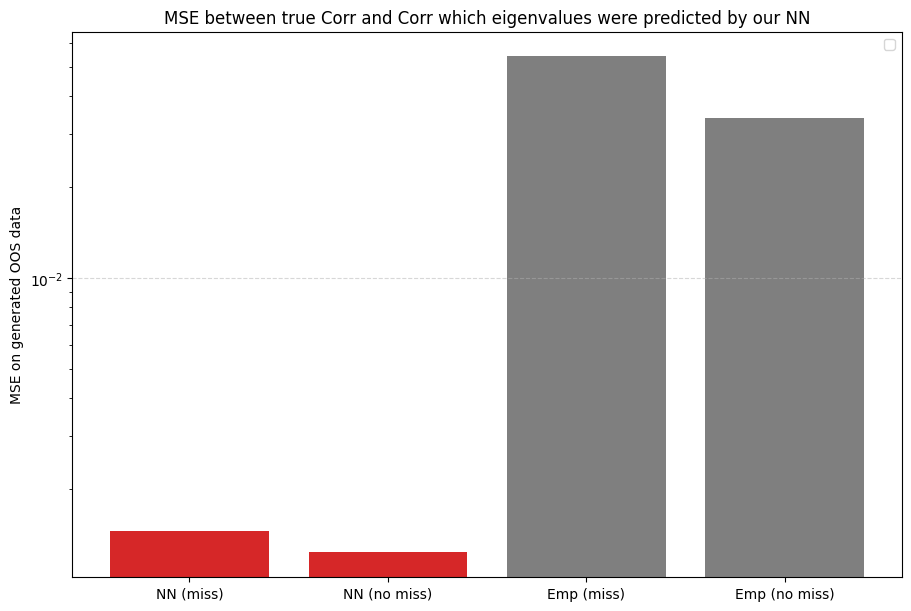

In [21]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)']
values = [fro_Corr_pred_miss.item(), fro_Corr_pred_no_miss.item(), fro_Corr_emp_miss.item(), fro_Corr_emp_no_miss.item()]
colors = ['tab:red','tab:red','tab:gray','tab:gray']#,, 'tab:gray''tab:gray']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('MSE on generated OOS data')
plt.title("MSE between true Corr and Corr which eigenvalues were predicted by our NN")
plt.grid(axis='y', ls='--', alpha=.5)
plt.legend()
plt.show()


Comparaison matrix $\Sigma$

In [22]:
Sigma_pred_miss    = torch.sqrt(torch.diag_embed(Sigma_hat_diag_miss)).float() @ Corr_pred_miss @ torch.sqrt(torch.diag_embed(Sigma_hat_diag_miss)).float()
Sigma_pred_no_miss = torch.sqrt(torch.diag_embed(Sigma_hat_diag_no_miss)).float() @ Corr_pred_no_miss @ torch.sqrt(torch.diag_embed(Sigma_hat_diag_no_miss)).float()
Sigma_emp_miss     = torch.sqrt(torch.diag_embed(Sigma_hat_diag_miss)).float() @ Corr_emp_miss @  torch.sqrt(torch.diag_embed(Sigma_hat_diag_miss)).float()
Sigma_emp_no_miss  = torch.sqrt(torch.diag_embed(Sigma_hat_diag_no_miss)).float() @ Corr_emp_no_miss @ torch.sqrt(torch.diag_embed(Sigma_hat_diag_no_miss)).float()

#Sigma_near_miss    = nearcorr_batch(Sigma_emp_miss, tol = (1e-6, 1e-6))
#Sigma_near_no_miss = nearcorr_batch(Sigma_emp_no_miss, tol = (1e-6, 1e-6))

In [23]:
Sigma_QIS = QIS_batched(R_no_miss)
# Sigma_QIS_miss = QIS_batched(R_miss) no sense 
lam_QIS, _ = torch.linalg.eigh(Sigma_QIS)
lam_QIS[0]

tensor([0.7433, 0.8200, 0.8530, 0.8530, 0.8530, 0.8530, 0.8530, 0.8530, 0.8530,
        0.8530, 0.8530, 0.8530, 0.8530, 0.8530, 0.8530, 0.8530, 0.8530, 0.8530,
        0.8530, 0.8530, 0.8530, 0.8530, 0.8530, 0.8530, 0.8530, 0.8530, 0.8530,
        0.8530, 0.8530, 0.8530, 0.8530, 0.8530, 0.8530, 0.8906, 0.9449, 0.9566,
        0.9588, 0.9751, 0.9908, 0.9976, 1.0343, 1.0397, 1.0451, 1.0609, 1.0673,
        1.0815, 1.0902, 1.0920, 1.1366, 1.1447, 1.1583, 1.1593, 1.1636, 1.1986,
        1.2113, 1.2599, 1.4020, 1.4341, 1.5492, 1.8234], dtype=torch.float64)

In [24]:
lam_emp_no_miss[0]

tensor([ 4.9472e+00,  4.6957e+00,  4.2587e+00,  4.1596e+00,  4.0030e+00,
         3.5276e+00,  3.2993e+00,  3.1319e+00,  2.7194e+00,  2.5611e+00,
         2.3846e+00,  2.2044e+00,  2.0128e+00,  1.9341e+00,  1.7876e+00,
         1.7157e+00,  1.5809e+00,  1.3777e+00,  1.2713e+00,  1.1966e+00,
         9.5756e-01,  9.1228e-01,  8.4127e-01,  7.0009e-01,  5.8747e-01,
         3.6847e-01,  3.4999e-01,  2.8215e-01,  2.3145e-01,  1.0000e-08,
         1.0000e-08,  9.9828e-09,  9.9539e-09,  9.8811e-09,  9.8341e-09,
         9.7086e-09,  9.5541e-09,  9.2147e-09,  9.1125e-09,  8.7473e-09,
         7.9434e-09,  7.6313e-09,  6.9502e-09,  6.7323e-09,  6.0490e-09,
         4.7656e-09,  4.4262e-09,  2.9538e-09,  2.3995e-09,  1.7826e-09,
        -9.2938e-10, -1.4653e-09, -6.0255e-09, -9.7734e-09, -1.0361e-08,
        -1.2492e-08, -1.8830e-08, -3.5760e-08, -4.4223e-08, -5.5095e-08])

In [25]:
eigv, _ = torch.linalg.eigh(Sigma_true_no_miss)
eigv[0]

tensor([0.7832, 0.7887, 0.8136, 0.8212, 0.8300, 0.8384, 0.8409, 0.8463, 0.8610,
        0.8643, 0.8740, 0.8801, 0.8832, 0.8898, 0.9021, 0.9027, 0.9051, 0.9101,
        0.9157, 0.9213, 0.9226, 0.9269, 0.9401, 0.9413, 0.9538, 0.9583, 0.9662,
        0.9717, 0.9754, 0.9852, 0.9952, 0.9985, 1.0018, 1.0082, 1.0220, 1.0327,
        1.0366, 1.0478, 1.0516, 1.0531, 1.0604, 1.0709, 1.0746, 1.0802, 1.0973,
        1.1011, 1.1110, 1.1120, 1.1214, 1.1397, 1.1437, 1.1543, 1.1646, 1.1716,
        1.1822, 1.2041, 1.2169, 1.2285, 1.2455, 1.2573], dtype=torch.float64)

In [26]:
lam_pred_no_miss[0]

tensor([0.7846, 0.7843, 0.7863, 0.7880, 0.7890, 0.7891, 0.7890, 0.7887, 0.7880,
        0.7876, 0.7871, 0.7866, 0.7861, 0.7858, 0.7854, 0.7851, 0.7848, 0.7842,
        0.7838, 0.7836, 0.7829, 0.7826, 0.7823, 0.7819, 0.7814, 0.7807, 0.7805,
        0.7802, 0.7799, 0.7791, 0.7789, 0.7787, 0.7786, 0.7784, 0.7781, 0.7779,
        0.7776, 0.7772, 0.7769, 0.7764, 0.7760, 0.7755, 0.7749, 0.7742, 0.7735,
        0.7727, 0.7718, 0.7708, 0.7697, 0.7684, 0.7669, 0.7652, 0.7633, 0.7610,
        0.7585, 0.7555, 0.7519, 0.7474, 0.7409, 0.7202],
       grad_fn=<SelectBackward0>)

In [27]:
fro_Sigma_pred_miss    = mse(Sigma_pred_miss, Sigma_true_miss)
fro_Sigma_pred_no_miss = mse(Sigma_pred_no_miss, Sigma_true_no_miss)
fro_Sigma_emp_miss     = mse(Sigma_emp_miss, Sigma_true_miss)
fro_Sigma_emp_no_miss  = mse(Sigma_emp_no_miss, Sigma_true_no_miss)
fro_Sigma_QIS          = mse(Sigma_QIS, Sigma_true_no_miss)
#fro_Sigma_QIS_miss     = mse(Sigma_QIS_miss, Sigma_true_miss) no sense
#fro_Sigma_near_miss    = mse(Sigma_near_miss, Sigma_true_miss)
#fro_Sigma_near_no_miss = mse(Sigma_near_no_miss, Sigma_true_no_miss)

print(f"MSE Sigma after miss + NN:         {fro_Sigma_pred_miss:.6f}")
print(f"MSE Sigma after no miss + NN :     {fro_Sigma_pred_no_miss:.6f}")
print(f"MSE Sigma after miss + no NN :     {fro_Sigma_emp_miss:.6f}")
print(f"MSE Sigma after no miss  + no NN : {fro_Sigma_emp_no_miss:.6f}")
print(f"MSE Sigma QIS :                    {fro_Sigma_QIS:.6f}")
#print(f"MSE Sigma QIS :                    {fro_Sigma_QIS_miss:.6f}")
#print(f"MSE Sigma nearest PD miss :        {fro_Sigma_near_miss:.6f}")
#print(f"MSE Sigma nearest PD no miss :     {fro_Sigma_near_no_miss:.6f}")

MSE Sigma after miss + NN:         0.002374
MSE Sigma after no miss + NN :     0.001900
MSE Sigma after miss + no NN :     0.055718
MSE Sigma after no miss  + no NN : 0.035175
MSE Sigma QIS :                    0.001153


Graphique : 

/var/folders/l1/kv6fjcx118x75w1kjzdxphsm0000gp/T/ipykernel_76237/3647656458.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


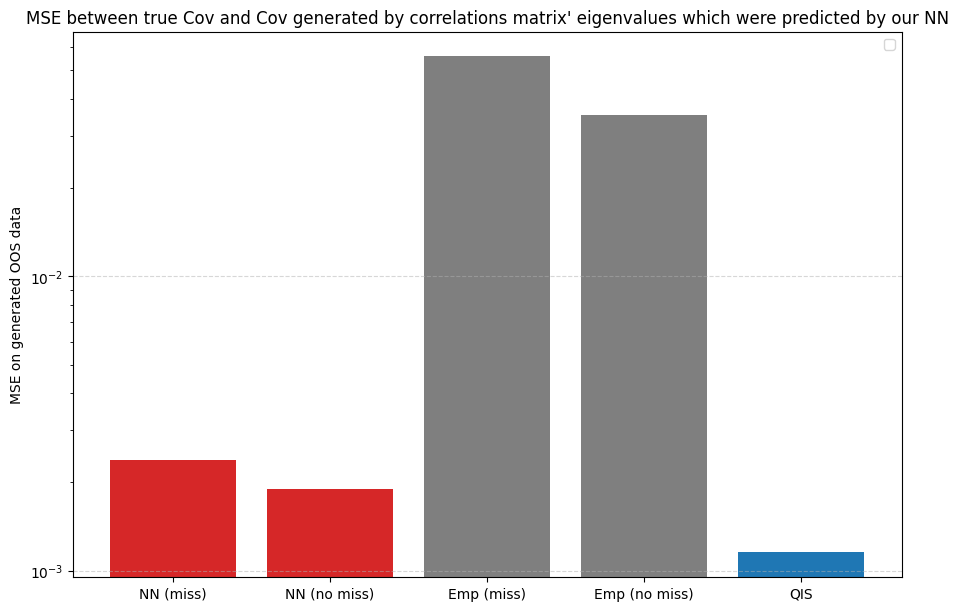

In [28]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)', 'QIS']# 'projected Em (miss)' 'projected Em (no miss)']
values = [fro_Sigma_pred_miss.item(), fro_Sigma_pred_no_miss.item(), fro_Sigma_emp_miss.item(), fro_Sigma_emp_no_miss.item(), fro_Sigma_QIS.item()]# fro_Sigma_near_miss.item(), fro_Sigma_near_no_miss.item()]
colors = ['tab:red','tab:red','tab:gray','tab:gray', 'tab:blue']#,, 'tab:gray''tab:gray']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('MSE on generated OOS data')
plt.title("MSE between true Cov and Cov generated by correlations matrix' eigenvalues which were predicted by our NN")
plt.grid(axis='y', ls='--', alpha=.5)
plt.legend()
plt.show()


We except this on generated data, YES very good ! Our method beats all of the tested method wether it is missing data or not! (what matter is when it misses data)

We can approximate Wishart distribution with a NN ! 

$Loss = ||\Sigma_{true} - \Sigma_{methods}||_{F} * \alpha $ Potters-Bouchaux loss, see experience

Now application to real financial data :
$Loss = ||\Sigma_{IS} - \Sigma_{OOS}||_{F} * \alpha $ 

### Surface (oos)

In [ ]:
batch_size_oos_1 = 25
N_list_test_1 = [20, 40, 60, 80, 100, 120, 140, 160, 180,200,220, 240]
T_list_test_1 = [20, 30, 40, 50, 60, 80, 100, 120, 150, 200, 220]

In [ ]:
losses_value = np.zeros((len(N_list_test_1), len(T_list_test_1)))
mse_value    = np.zeros((len(N_list_test_1), len(T_list_test_1)))

In [ ]:
for i_n in range(len(N_list_test_1)):
    for j_t in range(len(T_list_test_1)):
        input_seq, Q_emp_oos_i, Sigma_true_oos_i, T_t, D, R = next(data_generator(batch_size=batch_size_oos_1, missing_constant=2, N_min=N_list_test_1[i_n], N_max=N_list_test_1[i_n], T_min=T_list_test_1[j_t], T_max=T_list_test_1[j_t]))
        lam_pred_test_i = model_generated_data(input_seq, input_seq[:,:,0])
        Sigma_pred_oos_i = torch.sqrt(torch.diag_embed(D)).float() @ Q_emp_oos_i @ torch.diag_embed(lam_pred_test_i) @ Q_emp_oos_i.transpose(1, 2) @ torch.sqrt(torch.diag_embed(D)).float()
    
        losses_value[i_n, j_t] =(loss_function_mat(Sigma_pred_oos_i, Sigma_true_oos_i, T_list_test_1[j_t]).item())
        mse_value[i_n, j_t] = (mse(Sigma_true_oos_i, Sigma_pred_oos_i).item())

In [ ]:
# meshing
N_mesh, T_mesh = np.meshgrid(N_list_test_1, T_list_test_1, indexing="ij")

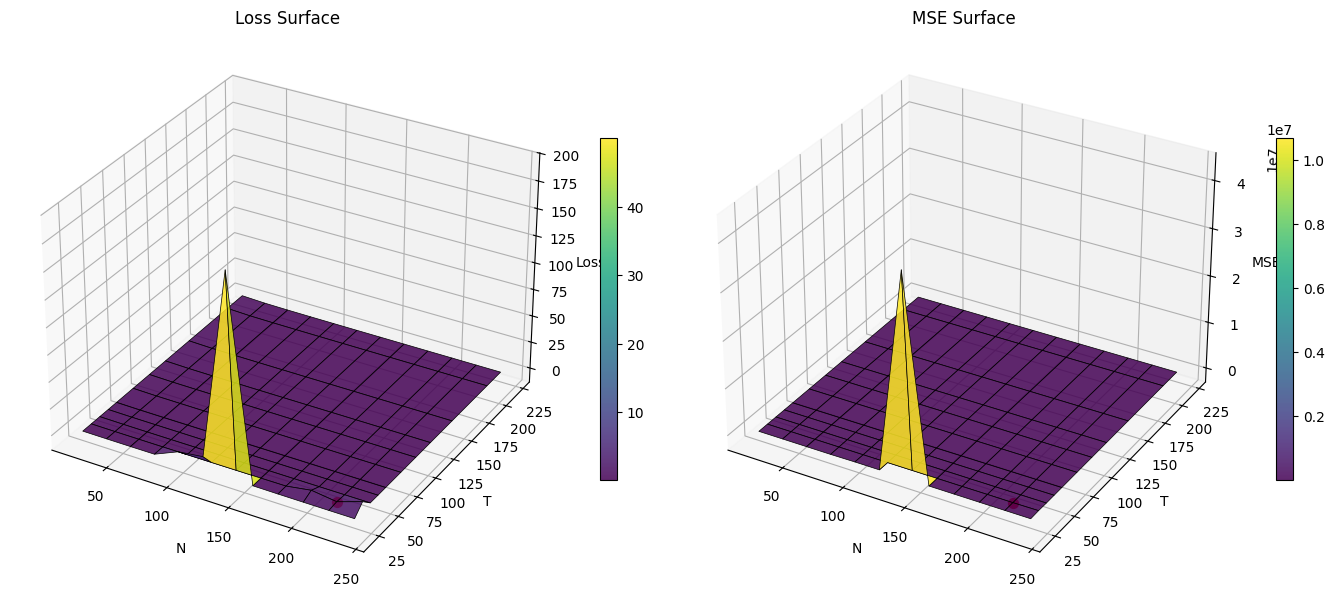

In [ ]:
fig = plt.figure(figsize=(14, 6))

ax_loss = fig.add_subplot(1, 2, 1, projection="3d")
ax_mse  = fig.add_subplot(1, 2, 2, projection="3d")

# --- Loss surface ---
surf_loss = ax_loss.plot_surface(
    N_mesh, T_mesh, losses_value,
    cmap="viridis",
    edgecolor="k",
    linewidth=0.5,
    alpha=0.85,
)

ax_loss.set(
    xlabel="N",
    ylabel="T",
    zlabel="Loss",
    title="Loss Surface",
)

ax_loss.scatter(N_list_test_1[10], T_list_test_1[1], losses_value[10, 1]*1, c="red", s=50)

# --- MSE surface ---
surf_mse = ax_mse.plot_surface(
    N_mesh, T_mesh, mse_value,
    cmap="viridis",
    edgecolor="k",
    linewidth=0.5,
    alpha=0.85,
)

ax_mse.set(
    xlabel="N",
    ylabel="T",
    zlabel="MSE",
    title="MSE Surface",
)

ax_mse.scatter(N_list_test_1[10], T_list_test_1[1], mse_value[10, 1], c="red", s=50)

# Colorbars (one per surface, clean & honest)
fig.colorbar(surf_loss, ax=ax_loss, shrink=0.6)
fig.colorbar(surf_mse,  ax=ax_mse,  shrink=0.6)

plt.tight_layout()
plt.savefig("images/loss_surface_double.png")
plt.show()

small N is not part of what we are training which is why noise increase with small N eventhough it should be small

### BackTesting / Application Trying on real financial data

When you have real data, you don't have $\Sigma_{true}$ you only have for instance $R = (r_0, ..., r_T)$ and $R_{oos} = (r_{T+1}, ... ,r_{T+10})$  (10 is maximum ! — CB, more have no sense)

In [33]:
dataset = real_data_pipeline(
    batch_size,
    date_bounds=('1995-01-01','2015-01-01'),
    n_days_out = 10,
    n_days_in = T_max,
    shift = 1, # cus that day in rn
    n_stocks = N_max,
    market_cap_range = (1000, 3000),
    sequential = False,
    return_generator = False,
)

In [34]:
input_seq_miss, Q_emp_miss, R_oos_miss, T, Sigma_hat_diag_miss             = next(data_generator_real_data(missing_constant = 2, N_min=N_min, N_max=N_max, T_min=T_min, T_max=T_max, dataset=dataset))
input_seq_no_miss, Q_emp_no_miss, R_oos_no_miss, T, Sigma_hat_diag_no_miss = next(data_generator_real_data(missing_constant = 1, N_min=N_min, N_max=N_max, T_min=T_min, T_max=T_max, dataset=dataset))

In [35]:
Sigma_true_miss    = torch_cov_pairwise(R_oos_miss)
Sigma_true_no_miss = torch_cov_pairwise(R_oos_no_miss)

In [36]:
lam_pred_miss       = model_generated_data(input_seq_miss)
lam_emp_cov_miss    = input_seq_miss[:,:,0]
lam_pred_no_miss    = model_generated_data(input_seq_no_miss)
lam_emp_cov_no_miss = input_seq_no_miss[:,:,0]

Comparaison matrix $Corr$

In [38]:
Corr_pred_miss    = Q_emp_miss @ torch.diag_embed(lam_pred_miss) @ Q_emp_miss.transpose(1,2)
Corr_pred_no_miss = Q_emp_no_miss @ torch.diag_embed(lam_pred_no_miss) @ Q_emp_no_miss.transpose(1,2)
Corr_emp_miss     = Q_emp_miss @ torch.diag_embed(lam_pred_miss) @ Q_emp_miss.transpose(1,2)
Corr_emp_no_miss  = Q_emp_no_miss @ torch.diag_embed(lam_pred_no_miss) @ Q_emp_no_miss.transpose(1,2)

In [39]:
diag_oos_miss  = torch.diagonal(Sigma_true_miss, dim1=-2, dim2=-1)
std_oos_miss   = torch.sqrt(torch.clamp(diag_oos_miss, min=1e-12))
Corr_true_miss = Sigma_true_miss / (std_oos_miss[:, None, :] * std_oos_miss[:, :, None] + 1e-12)


diag_oos_no_miss  = torch.diagonal(Sigma_true_no_miss, dim1=-2, dim2=-1)
std_oos_no_miss   = torch.sqrt(torch.clamp(diag_oos_no_miss, min=1e-12))
Corr_true_no_miss = Sigma_true_no_miss / (std_oos_no_miss[:, None, :] * std_oos_no_miss[:, :, None] + 1e-12)

In [40]:
fro_Corr_pred_miss    = mse(Corr_pred_miss, Sigma_true_miss)
fro_Corr_pred_no_miss = mse(Corr_pred_no_miss, Sigma_true_no_miss)
fro_Corr_emp_miss     = mse(Corr_emp_miss, Sigma_true_miss)
fro_Corr_emp_no_miss  = mse(Corr_emp_no_miss, Sigma_true_no_miss)


print(f"MSE Corr after miss + NN:         {fro_Corr_pred_miss:.6f}")
print(f"MSE Corr after no miss + NN :     {fro_Corr_pred_no_miss:.6f}")
print(f"MSE Corr after miss + no NN :     {fro_Corr_emp_miss:.6f}")
print(f"MSE Corr after no miss  + no NN : {fro_Corr_emp_no_miss:.6f}")

MSE Corr after miss + NN:         0.195966
MSE Corr after no miss + NN :     0.210400
MSE Corr after miss + no NN :     0.195966
MSE Corr after no miss  + no NN : 0.210400


/var/folders/l1/kv6fjcx118x75w1kjzdxphsm0000gp/T/ipykernel_36868/3329112023.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


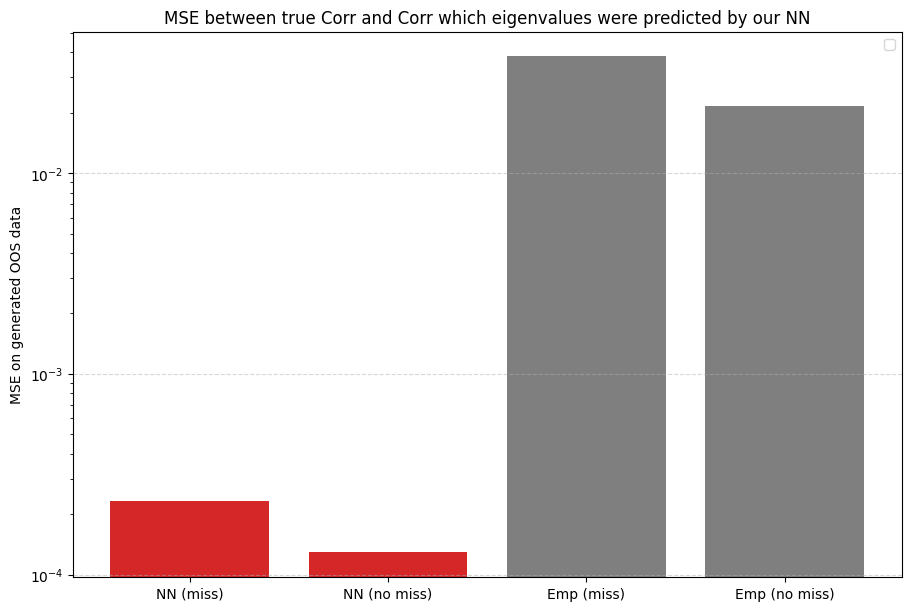

In [ ]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)']
values = [fro_Corr_pred_miss.item(), fro_Corr_pred_no_miss.item(), fro_Corr_emp_miss.item(), fro_Corr_emp_no_miss.item()]
colors = ['tab:red','tab:red','tab:gray','tab:gray']#,, 'tab:gray''tab:gray']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('MSE on generated OOS real data')
plt.title("MSE between true Corr and Corr which eigenvalues were predicted by our NN")
plt.grid(axis='y', ls='--', alpha=.5)
plt.legend()
plt.show()


Comparaison matrix $\Sigma$

In [ ]:
Sigma_pred_miss    = torch.sqrt(torch.diag_embed(Sigma_hat_diag_miss)).float() @ Corr_pred_miss @ torch.sqrt(torch.diag_embed(Sigma_hat_diag_miss)).float()
Sigma_pred_no_miss = torch.sqrt(torch.diag_embed(Sigma_hat_diag_no_miss)).float() @ Corr_pred_no_miss @ torch.sqrt(torch.diag_embed(Sigma_hat_diag_no_miss)).float()
Sigma_emp_miss     = torch.sqrt(torch.diag_embed(Sigma_hat_diag_miss)).float() @ Corr_emp_miss @  torch.sqrt(torch.diag_embed(Sigma_hat_diag_miss)).float()
Sigma_emp_no_miss  = torch.sqrt(torch.diag_embed(Sigma_hat_diag_no_miss)).float() @ Corr_emp_no_miss @ torch.sqrt(torch.diag_embed(Sigma_hat_diag_no_miss)).float()

#Sigma_near_miss    = nearcorr_batch(Sigma_emp_miss, tol = (1e-6, 1e-6))
#Sigma_near_no_miss = nearcorr_batch(Sigma_emp_no_miss, tol = (1e-6, 1e-6))

In [ ]:
Sigma_QIS          = Q_QIS @ torch.diag_embed(lam_QIS.squeeze(-1)) @ Q_QIS.transpose(1,2)
Sigma_QIS_miss     = Q_QIS_miss @ torch.diag_embed(lam_QIS_miss.squeeze(-1)) @ Q_QIS_miss.transpose(1,2)

In [ ]:
fro_Sigma_pred_miss    = mse(Sigma_pred_miss, Sigma_true_miss)
fro_Sigma_pred_no_miss = mse(Sigma_pred_no_miss, Sigma_true_no_miss)
fro_Sigma_emp_miss     = mse(Sigma_emp_miss, Sigma_true_miss)
fro_Sigma_emp_no_miss  = mse(Sigma_emp_no_miss, Sigma_true_no_miss)
fro_Sigma_QIS          = mse(Sigma_QIS, Sigma_true_no_miss)
fro_Sigma_QIS_miss     = mse(Sigma_QIS_miss, Sigma_true_miss)

#fro_Sigma_near_miss    = mse(Sigma_near_miss, Sigma_true_miss)
#fro_Sigma_near_no_miss = mse(Sigma_near_no_miss, Sigma_true_no_miss)

print(f"MSE Sigma after miss + NN:         {fro_Sigma_pred_miss:.6f}")
print(f"MSE Sigma after no miss + NN :     {fro_Sigma_pred_no_miss:.6f}")
print(f"MSE Sigma after miss + no NN :     {fro_Sigma_emp_miss:.6f}")
print(f"MSE Sigma after no miss  + no NN : {fro_Sigma_emp_no_miss:.6f}")
print(f"MSE Sigma QIS :                    {fro_Sigma_QIS:.6f}")
print(f"MSE Sigma QIS :                    {fro_Sigma_QIS_miss:.6f}")

#print(f"MSE Sigma nearest PD miss :        {fro_Sigma_near_miss:.6f}")
#print(f"MSE Sigma nearest PD no miss :     {fro_Sigma_near_no_miss:.6f}")

MSE Sigma after miss + NN:         0.000871
MSE Sigma after no miss + NN :     0.000331
MSE Sigma after miss + no NN :     0.038745
MSE Sigma after no miss  + no NN : 0.021798
MSE Sigma QIS :                    0.000193
MSE Sigma QIS :                    0.000450


Graphique : 

/var/folders/l1/kv6fjcx118x75w1kjzdxphsm0000gp/T/ipykernel_36868/216677801.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


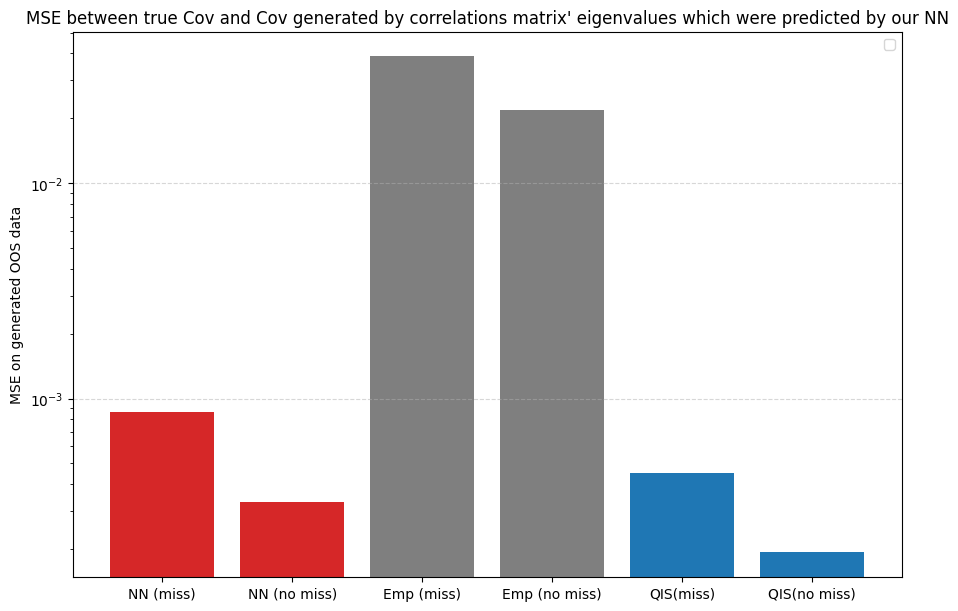

In [ ]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)', 'QIS(miss)', 'QIS(no miss)']#, 'projected Em (miss)' 'projected Em (no miss)']
values = [fro_Sigma_pred_miss.item(), fro_Sigma_pred_no_miss.item(), fro_Sigma_emp_miss.item(), fro_Sigma_emp_no_miss.item(), fro_Sigma_QIS_miss.item(), fro_Sigma_QIS.item()]#, fro_Sigma_near_miss.item(), fro_Sigma_near_no_miss.item()]
colors = ['tab:red','tab:red','tab:gray','tab:gray', 'tab:blue', 'tab:blue']#,, 'tab:gray''tab:gray']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('MSE on generated OOS data')
plt.title("MSE between true Cov and Cov generated by correlations matrix' eigenvalues which were predicted by our NN")
plt.grid(axis='y', ls='--', alpha=.5)
plt.legend()
plt.show()


In [31]:
Sigma_pred_miss    = reconstruct_cov(Q_emp_miss, lam_pred_miss)
Sigma_pred_no_miss = reconstruct_cov(Q_emp_no_miss, lam_pred_no_miss)
Sigma_emp_miss     = reconstruct_cov(Q_emp_miss, lam_emp_cov_miss)
Sigma_emp_no_miss  = reconstruct_cov(Q_emp_no_miss, lam_emp_cov_no_miss)
#Sigma_near_miss    = nearcorr_batch(Sigma_emp_miss, tol = (1e-8, 1e-8))
#Sigma_near_no_miss = nearcorr_batch(Sigma_emp_no_miss, tol = (1e-8, 1e-8))
# Sigma_QIS          = reconstruct_cov(Q_QIS, lam_QIS) QIS requires no missingness (Can't compute QIS, bc matrix isn't positive define => normal)

fro_Sigma_pred_miss    = mse(Sigma_pred_miss, Sigma_true_miss)
fro_Sigma_pred_no_miss = mse(Sigma_pred_no_miss, Sigma_true_no_miss)
fro_Sigma_emp_miss     = mse(Sigma_emp_miss, Sigma_true_miss)
fro_Sigma_emp_no_miss  = mse(Sigma_emp_no_miss, Sigma_true_no_miss)
#fro_Sigma_near_miss    = mse(Sigma_near_miss, Sigma_true_miss)
#fro_Sigma_near_no_miss = mse(Sigma_near_no_miss, Sigma_true_no_miss)
# fro_Sigma_QIS          = mse(Sigma_QIS, Sigma_true_no_miss)

print(f"MSE Sigma after miss + NN:         {fro_Sigma_pred_miss:.6f}")
print(f"MSE Sigma after no miss + NN :     {fro_Sigma_pred_no_miss:.6f}")
print(f"MSE Sigma after miss + no NN :     {fro_Sigma_emp_miss:.7f}")
print(f"MSE Sigma after no miss  + no NN : {fro_Sigma_emp_no_miss:.7f}")
#print(f"MSE Sigma nearest PD miss :        {fro_Sigma_near_miss:.6f}")
#print(f"MSE Sigma nearest PD no miss :     {fro_Sigma_near_no_miss:.6f}")
# print(f"MSE Sigma QIS :                    {fro_Sigma_QIS:.6f}")

MSE Sigma after miss + NN:         0.200060
MSE Sigma after no miss + NN :     0.213577
MSE Sigma after miss + no NN :     0.1688120
MSE Sigma after no miss  + no NN : 0.1565776


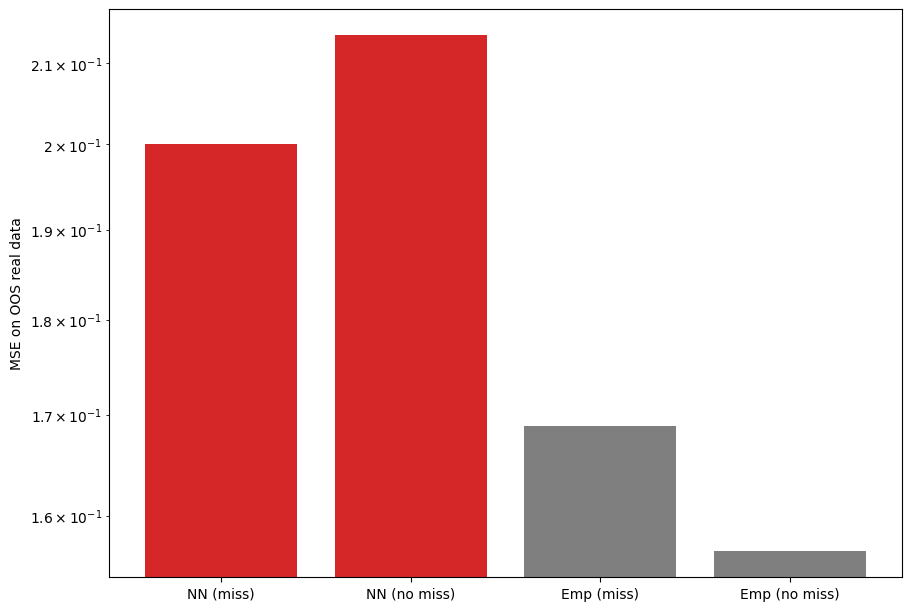

In [32]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)']#, 'near Emp (miss)', 'near Emp (no miss)']
values = [fro_Sigma_pred_miss.item(), fro_Sigma_pred_no_miss.item(), fro_Sigma_emp_miss.item(), fro_Sigma_emp_no_miss.item()]#, fro_Sigma_near_miss.item(), fro_Sigma_near_no_miss.item()]
colors = ['tab:red','tab:red','tab:gray','tab:gray']#,'tab:gray','tab:gray']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('MSE on OOS real data')
plt.grid(axis='y', ls='--', alpha=.5)
plt.show()


Our method fails here, but there is many reason, the first being that the data isn't map perfectly by a wishart distribution for instance. Let's training on real data to tackle that issue

Also I don't understand why near PD is that much furthur

### Add hyperparameter selection

To be added
- Make data transformer in Class so they be passed in (suggested CB)
- we could add : eigenvalues monotonically decreasing
- hyperparameter tuning
- k split cross validation

To be written in the report
- Write abt RIE and that we do smt simular
- Write abt GRU and how it helps us here
- A problem is that eigenVector are noisy
- write about QIS — QIS near to perfect — dig in report theory
- write about how q interfere in frobenus norm => need for Potters-Bouchaud - Application : all N and T are equivalent to test at the end

Tried
- stochastic gradient descent


- removed comparaison with trace : if necessary it can be normalized at the output of our network $\lambda_j * N / \sum_{i=1}^{N}\lambda_i $
- removed comparaison with eigenvalues : not meaning full as they are in another base !

Covariances depend on scale

Correlations are scale-invariant $\rho_{ij} = \frac{\Sigma_{ij}}{\sigma_i \sigma_j + \epsilon_i}$

=> should we then learn on correlation instead of covariance

Some stocks do not move at all over 10 days  
- variance = 0  
- correlation = NaN  
=> thus there is $\epsilon$

**Application**  
Compute $w = \frac{\hat{\Sigma}^{-1} \mathbb{1}}{\mathbb{1}^T\hat\Sigma\mathbb{1}}$   
Then compute $P_{oos} = w^T(r_{T+1} ... r_{T+10})$ Then sum and you get the expected return for the next d (=10 here) days  

What loss to use ? I try to maximize the profit for now switch to $n w^T \Sigma_{oos} w$